In [2]:
# First, install necessary libraries
import time
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import numpy as np
import botocore
import logging
from multiprocessing import Pool, Manager
import pandas as pd
import os
import sys
import functools
from urllib import request

In [4]:

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

def download(bucket, root, retry, counter, lock, path):
    i = 0
    src = path
    dest = f"{root}/{path}"
    while i < retry:
        try:
            if not os.path.exists(dest):
                s3.download_file(bucket, src, dest)
            else:
                logging.info(f"{dest} already exists.")
            with lock:
                counter.value += 1
                if counter.value % 100 == 0:
                    logging.warning(f"Downloaded {counter.value} images.")
            return
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                logging.warning(f"The file s3://{bucket}/{src} does not exist.")
                return
            i += 1
            logging.warning(f"Sleep {i} and try again.")
            time.sleep(i)
    logging.warning(f"Failed to download the file s3://{bucket}/{src}. Exception: {e}")

def batch_download(bucket, file_paths, root, num_workers=10, retry=10):
    with Pool(num_workers) as p:
        m = Manager()
        counter = m.Value('i', 0)
        lock = m.Lock()
        download_ = functools.partial(download, bucket, root, retry, counter, lock)
        p.map(download_, file_paths)

def http_download(url, path):
    with request.urlopen(url) as f:
        with open(path, "wb") as fout:
            buf = f.read(1024)
            while buf:
                fout.write(buf)
                buf = f.read(1024)

def log_counts(values):
    for k, count in values.value_counts().items():  # Changed iteritems() to items()
        logging.warning(f"{k}: {count}/{len(values)} = {count/len(values):.2f}.")


# Argument Simulation for Colab
class Args:
    root = './open_images_data'
    include_depiction = False
    class_names = "Aircraft,Aeroplane"
    num_workers = 2
    retry = 10
    filter_file = ""
    remove_overlapped = False

args = Args()

# Create root directory if it doesn't exist
os.makedirs(args.root, exist_ok=True)

# Start processing based on arguments
bucket = "open-images-dataset"
names = [e.strip() for e in args.class_names.split(",")]
class_names = []
group_filters = []
percentages = []
for name in names:
    t = name.split(":")
    class_names.append(t[0].strip())
    if len(t) >= 2 and t[1].strip():
        group_filters.append(t[1].strip())
    else:
        group_filters.append("")
    if len(t) >= 3 and t[2].strip():
        percentages.append(float(t[2].strip()))
    else:
        percentages.append(1.0)

# Exclude images if a filter file is provided
excluded_images = set()
if args.filter_file:
    for line in open(args.filter_file):
        img_id = line.strip()
        if not img_id:
            continue
        excluded_images.add(img_id)

# Download class description file
class_description_file = os.path.join(args.root, "class-descriptions-boxable.csv")
if not os.path.exists(class_description_file):
    url = "https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv"
    logging.warning(f"Download {url}.")
    http_download(url, class_description_file)

# Load the class descriptions to filter by selected classes
class_descriptions = pd.read_csv(class_description_file, names=["id", "ClassName"])
class_descriptions = class_descriptions[class_descriptions['ClassName'].isin(class_names)]

# Download images by dataset type (train, validation, test)
image_files = []
for dataset_type in ["train", "validation", "test"]:
    image_dir = os.path.join(args.root, dataset_type)
    os.makedirs(image_dir, exist_ok=True)

    annotation_file = f"{args.root}/{dataset_type}-annotations-bbox.csv"
    if not os.path.exists(annotation_file):
        url = f"https://storage.googleapis.com/openimages/2018_04/{dataset_type}/{dataset_type}-annotations-bbox.csv"
        logging.warning(f"Download {url}.")
        http_download(url, annotation_file)
    logging.warning(f"Read annotation file {annotation_file}")
    annotations = pd.read_csv(annotation_file)
    annotations = pd.merge(annotations, class_descriptions, left_on="LabelName", right_on="id", how="inner")
    if not args.include_depiction:
        annotations = annotations.loc[annotations['IsDepiction'] != 1, :]

    # Apply filtering and exclusions
    filtered = []
    for class_name, group_filter, percentage in zip(class_names, group_filters, percentages):
        sub = annotations.loc[annotations['ClassName'] == class_name, :]
        excluded_images |= set(sub['ImageID'].sample(frac=1 - percentage))

        if group_filter == '~group':
            excluded_images |= set(sub.loc[sub['IsGroupOf'] == 1, 'ImageID'])
        elif group_filter == 'group':
            excluded_images |= set(sub.loc[sub['IsGroupOf'] == 0, 'ImageID'])
        filtered.append(sub)

    annotations = pd.concat(filtered)
    annotations = annotations.loc[~annotations['ImageID'].isin(excluded_images), :]

    if args.remove_overlapped:
        images_with_group = annotations.loc[annotations['IsGroupOf'] == 1, 'ImageID']
        annotations = annotations.loc[~(annotations['ImageID'].isin(set(images_with_group)) & (annotations['IsGroupOf'] == 0)), :]
    annotations = annotations.sample(frac=1.0)

    logging.warning(f"{dataset_type} bounding boxes size: {annotations.shape[0]}")
    logging.warning("Approximate Image Stats: ")
    log_counts(annotations.drop_duplicates(["ImageID", "ClassName"])["ClassName"])
    logging.warning("Label distribution: ")
    log_counts(annotations['ClassName'])

    sub_annotation_file = f"{args.root}/sub-{dataset_type}-annotations-bbox.csv"
    logging.warning(f"Save {dataset_type} data to {sub_annotation_file}.")
    annotations.to_csv(sub_annotation_file, index=False)
    image_files.extend(f"{dataset_type}/{id}.jpg" for id in set(annotations['ImageID']))

logging.warning(f"Start downloading {len(image_files)} images.")
batch_download(bucket, image_files, args.root, args.num_workers, args.retry)
logging.warning("Task Done.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
!git clone https://github.com/qfgaohao/pytorch-ssd.git



fatal: destination path 'pytorch-ssd' already exists and is not an empty directory.


In [38]:
!pwd

/content


In [5]:
import sys
sys.path.append("/content/pytorch-ssd")

In [25]:
!python /content/pytorch-ssd/train_ssd.py \
    --dataset_type open_images \
    --datasets /content/open_images_data \
    --net mb1-ssd \
    --pretrained_ssd /content/pytorch-ssd/models/mobilenet-v1-ssd-mp-0_675.pth \
    --scheduler cosine \
    --lr 0.01 \
    --t_max 100 \
    --validation_epochs 5 \
    --num_epochs 20 \
    --base_net_lr 0.001 \
    --batch_size 5 \
    --checkpoint_folder /content/pytorch-ssd/models/ \
    --freeze_base_net


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2024-11-11 09:06:57,929 - root - INFO - Use Cuda.
2024-11-11 09:06:57,929 - root - INFO - Namespace(dataset_type='open_images', datasets=['/content/open_images_data'], validation_dataset=None, balance_data=False, net='mb1-ssd', freeze_base_net=True, freeze_net=False, mb2_width_mult=1.0, lr=0.01, momentum=0.9, weight_decay=0.0005, gamma=0.1, base_net_lr=0.001, extra_layers_lr=None, base_net=None, pretrained_ssd='/content/pytorch-ssd/models/mobilenet-v1-ssd-mp-0_675.pth', resume=None, scheduler='cosine', milestones='80,100', t_max=100.0, batch_size=5, num_epochs=20, num_workers=4, validation_epochs=5, debug_steps=100, use_cuda=True, checkpoint_folder=

In [29]:
!python pytorch-ssd/eval_ssd.py \
    --net mb1-ssd \
    --trained_model /content/pytorch-ssd/models/mb1-ssd-Epoch-19-Loss-4.53431602134261.pth \
    --dataset_type open_images \
    --dataset /content/open_images_data/test \
    --label_file /content/open_images_data/open-images-model-labels.txt \
    --use_cuda True \
    --iou_threshold 0.5 \
    --eval_dir /content/pytorch-ssd/eval_results
# !python /content/pytorch-ssd/eval_ssd.py \
#     --net mb1-ssd \
#     --dataset_type open_images \
#     --dataset /content/open_images_data/test \
#     --trained_model /content/pytorch-ssd/models/mobilenet-v1-ssd-mp-0_675.pth \
#     --label_file /content/open_images_data/open-images-model-labels.txt


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
/content/pytorch-ssd/eval_ssd.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt_boxes[class_index][image_id] = torch.tensor(all_gt_boxes[class_index][image_id])
/content/pytorch-ssd/vision/ssd/ssd.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

In [35]:
### results for original model ###
!python pytorch-ssd/eval_ssd.py \
    --net mb1-ssd \
    --trained_model /content/pytorch-ssd/models/mobilenet-v1-ssd-mp-0_675_pretrain.pth \
    --dataset_type open_images \
    --dataset /content/open_images_data/test \
    --label_file /content/open_images_data/open-images-model-labels.txt \
    --use_cuda True \
    --iou_threshold 0.5 \
    --eval_dir /content/pytorch-ssd/eval_results


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
/content/pytorch-ssd/eval_ssd.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt_boxes[class_index][image_id] = torch.tensor(all_gt_boxes[class_index][image_id])
/content/pytorch-ssd/vision/ssd/ssd.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

After fine-tuning the model for 20 epochs, the avg precision for the aircraft class improved from 0.2017 to 0.2761, which is a decent gain. This suggests the model has begun adapting to features of the new dataset but still needs  additional fine-tuning or hyperparameter adjustments. To further enhance AP, consider a lower learning rate, increasing the number of epochs.


In [36]:
!python /content/pytorch-ssd/convert_to_caffe2_models.py mb1-ssd \
    /content/pytorch-ssd/models/mb1-ssd-Epoch-19-Loss-4.53431602134261.pth \
    /content/open_images_data/open-images-model-labels.txt


Traceback (most recent call last):
  File "/content/pytorch-ssd/convert_to_caffe2_models.py", line 9, in <module>
    from caffe2.python.onnx.backend import Caffe2Backend as c2
ModuleNotFoundError: No module named 'caffe2'


In [42]:
!python /content/pytorch-ssd/convert_to_onnx_models.py mb1-ssd \
    /content/pytorch-ssd/models/mb1-ssd-Epoch-19-Loss-4.53431602134261.pth \
    /content/open_images_data/open-images-model-labels.txt


/content/pytorch-ssd/vision/ssd/ssd.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))


In [39]:
!pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 105.4 MB/s eta 0:00:00


In [43]:
import onnx

# Load the saved ONNX model
onnx_model_path = "/content/pytorch-ssd/models/mb1-ssd.onnx"
model = onnx.load(onnx_model_path)

# Verify the model’s structure
try:
    onnx.checker.check_model(model)
    print("The ONNX model structure is valid.")
except onnx.checker.ValidationError as e:
    print("The ONNX model structure is invalid:", e)


The ONNX model structure is valid.


In [44]:
!pip install onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


In [45]:
import onnxruntime as ort
import numpy as np

# Define the model path and create an ONNX Runtime inference session
onnx_model_path = "/content/pytorch-ssd/models/mb1-ssd.onnx"
session = ort.InferenceSession(onnx_model_path)

# Display the model's input and output names for reference
input_name = session.get_inputs()[0].name
output_names = [output.name for output in session.get_outputs()]
print("Input Name:", input_name)
print("Output Names:", output_names)

# Create a dummy input tensor with the shape expected by the model (e.g., batch size 1, 3 channels, 300x300 image)
dummy_input = np.random.randn(1, 3, 300, 300).astype(np.float32)

# Run the model and get the output
outputs = session.run(output_names, {input_name: dummy_input})

# Show the output for inspection
print("Model output scores:", outputs[0])  # Output scores
print("Model output boxes:", outputs[1])    # Output bounding boxes


Input Name: input.1
Output Names: ['scores', 'boxes']
Model output scores: [[[0.9812401  0.01875984]
  [0.9896458  0.01035417]
  [0.95239407 0.04760591]
  ...
  [0.8913681  0.10863195]
  [0.92840225 0.07159783]
  [0.90786034 0.09213968]]]
Model output boxes: [[[ 2.0111270e-02  2.3486909e-02  9.2707910e-02  9.7269580e-02]
  [-7.3224351e-02 -9.2235573e-02  1.3922818e-01  1.4815557e-01]
  [ 1.2119297e-02  3.6112197e-02  7.8048974e-02  7.4776717e-02]
  ...
  [ 2.3496449e-03  5.3672940e-02  9.5140386e-01  9.9243689e-01]
  [ 1.5386701e-02  3.9926052e-02  9.5258874e-01  9.8600960e-01]
  [ 3.3587217e-04  3.8519919e-02  9.4960421e-01  9.9136883e-01]]]


##Step 5

In [49]:
import numpy as np
import torch
import onnxruntime as ort
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt

pytorch_model_path = "/content/pytorch-ssd/models/mb1-ssd-Epoch-19-Loss-4.53431602134261.pth"
onnx_model_path = "/content/pytorch-ssd/models/mb1-ssd.onnx"

image_paths = ["/content/open_images_data/test/test/00835f0fbe950715.jpg", "/content/open_images_data/test/test/01d4c269fd96589d.jpg"]  # Paths to test images


In [50]:
# Preprocess images
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    return image.unsqueeze(0)  # Add batch dimension


images = [preprocess_image(path) for path in image_paths]


In [51]:

from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd


num_classes = 2  # Adjust this based on your dataset
model = create_mobilenetv1_ssd(num_classes=num_classes, is_test=True)
model.load_state_dict(torch.load(pytorch_model_path))
model = model.to("cuda")


def run_pytorch_inference(model, image_tensor):
    model.eval()
    with torch.no_grad():
        scores, boxes = model(image_tensor.to("cuda"))
    return scores.cpu().numpy(), boxes.cpu().numpy()

pytorch_scores, pytorch_boxes = run_pytorch_inference(model, images[0].to("cuda"))


<ipython-input-51-332911b6a0e1>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pytorch_model_path))


In [52]:
#ONNX runtime
ort_session = ort.InferenceSession(onnx_model_path)

def run_onnx_inference(session, image_tensor):
    ort_inputs = {session.get_inputs()[0].name: image_tensor.numpy()}
    ort_outs = session.run(None, ort_inputs)
    return ort_outs[0], ort_outs[1]

onnx_scores, onnx_boxes = run_onnx_inference(ort_session, images[0])


In [53]:
# Compar
def compare_outputs(pytorch_output, onnx_output, tolerance=1e-5):
    return np.allclose(pytorch_output, onnx_output, atol=tolerance)

scores_match = compare_outputs(pytorch_scores, onnx_scores)
boxes_match = compare_outputs(pytorch_boxes, onnx_boxes)
print(f"Do PyTorch and ONNX outputs match? Scores: {scores_match}, Boxes: {boxes_match}")


Do PyTorch and ONNX outputs match? Scores: True, Boxes: True


In [54]:
# Run inference with ONNX
ort_outputs = [run_onnx_inference(ort_session, img) for img in images]

for i, (scores, boxes) in enumerate(ort_outputs):
    print(f"Image {i+1} Output Scores:\n{scores}")
    print(f"Image {i+1} Output Boxes:\n{boxes}")


Image 1 Output Scores:
[[[0.98609936 0.01390067]
  [0.9922368  0.00776316]
  [0.9765129  0.02348709]
  ...
  [0.9138311  0.08616882]
  [0.88797045 0.11202951]
  [0.9385606  0.06143935]]]
Image 1 Output Boxes:
[[[ 8.45224783e-03  2.31708027e-02  9.94724482e-02  1.12552494e-01]
  [-8.86582881e-02 -7.63940066e-02  1.41702831e-01  1.68326065e-01]
  [-1.40358098e-02  3.18231136e-02  7.93265849e-02  8.37286040e-02]
  ...
  [ 1.00037754e-02  1.18435740e-01  9.29769278e-01  9.42582250e-01]
  [-5.73217869e-04  2.08032310e-01  9.53017712e-01  8.61026227e-01]
  [ 3.70020866e-02  8.51177275e-02  9.04490709e-01  9.65587258e-01]]]
Image 2 Output Scores:
[[[0.99659616 0.00340383]
  [0.99416274 0.00583728]
  [0.9891417  0.01085833]
  ...
  [0.87978977 0.12021025]
  [0.75105    0.24894999]
  [0.907893   0.09210702]]]
Image 2 Output Boxes:
[[[ 0.01511099  0.01073169  0.09782965  0.09936808]
  [-0.09298997 -0.12491205  0.14805041  0.19104698]
  [-0.01706864  0.02830485  0.04191089  0.07009736]
  ...
  [ 

In [57]:

def annotate_image(image_path, boxes, scores, threshold=0.5):
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    for i in range(len(scores)):
        if scores[i][0] > threshold:  # Adjust threshold as needed
            box = boxes[i]
            box = [int(b) for b in [box[0] * w, box[1] * h, box[2] * w, box[3] * h]]
            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
            cv2.putText(image, f"{scores[i][0]:.2f}", (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    return image


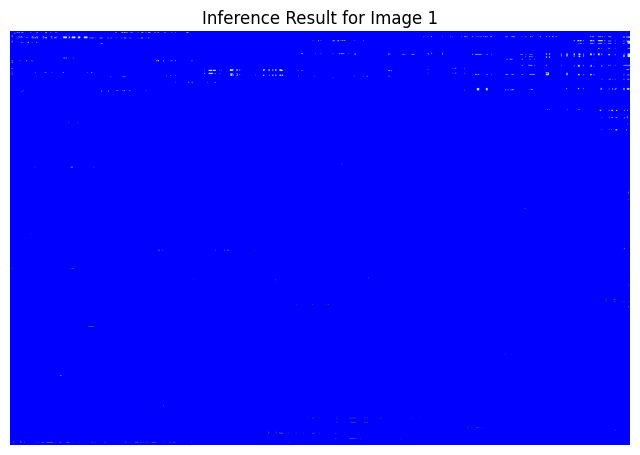

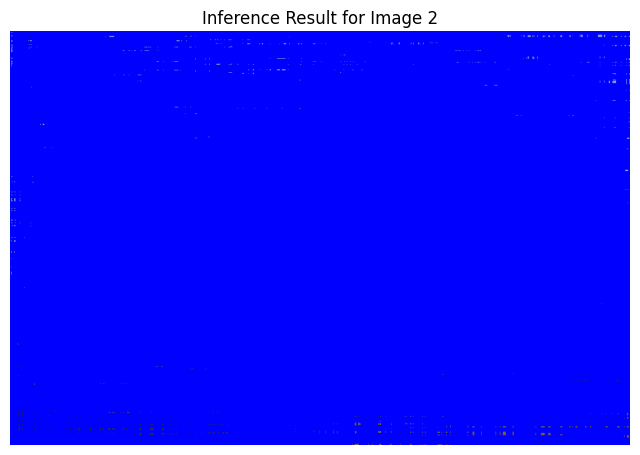

In [56]:
# Annotate
for i, img_path in enumerate(image_paths):
    annotated_image = annotate_image(img_path, ort_outputs[i][1][0], ort_outputs[i][0][0])  # using ONNX output
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Inference Result for Image {i+1}")
    plt.axis("off")
    plt.show()
